<a href="https://colab.research.google.com/github/Harshkotkar/Deep-Learning/blob/main/Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
kazanova_sentiment140_path = kagglehub.dataset_download('kazanova/sentiment140')
crowdflower_twitter_airline_sentiment_path = kagglehub.dataset_download('crowdflower/twitter-airline-sentiment')
bittlingmayer_amazonreviews_path = kagglehub.dataset_download('bittlingmayer/amazonreviews')
jp797498e_twitter_entity_sentiment_analysis_path = kagglehub.dataset_download('jp797498e/twitter-entity-sentiment-analysis')
parulpandey_emotion_dataset_path = kagglehub.dataset_download('parulpandey/emotion-dataset')

print('Data source import complete.')


Data source import complete.


* <b> Overview :</b> Explore text-based emotion recognition, a dynamic field in <span style="background-color: red; padding: 4px; border-radius:5px;">NLP</span>, focusing on deciphering diverse emotional states in textual content.

* <b> Objective :</b> Build a system for automatic categorization of text into six emotions
( <span style="color: #F8DE22;">joy</span>  ,
 <span style="color: #0c0d49;">sadness</span> ,
 <span style="color: #b82f2f;">fear</span> ,
 <span style="color: #331e1e;">anger</span > ,
 <span style="color: red;">love</span> ,
 <span style="color: #00fff7;">surprise</span>)
* <b> Model Choice : </b> Utilize <span style="background-color: #F8DE22; padding: 4px; border-radius:5px;">LSTM</span>
 (Long Short-Term Memory) networks, a type of <span style="background-color: #F8DE22; padding: 4px; border-radius:5px;">RNN</span>.

* <b> Implementation : </b>
Implemented with <span style="background-color: #F8DE22; padding: 4px; border-radius:5px;">TensorFlow</span>.



In [12]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
import numpy as np
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix


import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


# 1 | The Dataset

* any data sets involving sentiment analysis are <span style="background-color: #F8DE22; padding: 2px; border-radius:5px;">binary classification</span> problems
* In this dataset we have <span style="background-color: #F8DE22; padding: 2px; border-radius:5px;">6 different sentiments</span> , which means we'll be treating this problem as a <span style="background-color: #F8DE22; padding: 2px; border-radius:5px;">multiclass classification</span> problem

   ### 1. 1 | Loading Data

In [13]:
val_data = pd.read_csv('/kaggle/input/emotion-dataset/validation.csv')
train_data = pd.read_csv('/kaggle/input/emotion-dataset/training.csv')
test_data = pd.read_csv('/kaggle/input/emotion-dataset/test.csv')

In [14]:
print("Validation data :",val_data.shape)
print("Train data :",train_data.shape)
print("Test data :",test_data.shape)

Validation data : (2000, 2)
Train data : (16000, 2)
Test data : (2000, 2)


* There is a lot of data in test, in my case i divided it and put the est in the val_data

In [15]:
half_test_data = test_data.iloc[1000:]
test_data = test_data.iloc[:1000]

val_data = pd.concat([val_data, half_test_data], axis=0)

print("new Vald data :",val_data.shape)
print("new Test data :",test_data.shape)

new Vald data : (3000, 2)
new Test data : (1000, 2)


In [16]:
train_data.head(10)

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
5,ive been feeling a little burdened lately wasn...,0
6,ive been taking or milligrams or times recomme...,5
7,i feel as confused about life as a teenager or...,4
8,i have been with petronas for years i feel tha...,1
9,i feel romantic too,2


### 1. 2 | Adding Label Data

In [17]:
labels_dict = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
train_data['label_name'] = train_data['label'].map(labels_dict)
train_data.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [18]:
train_data.groupby(["label_name","label"]).size()

,,0
label_name,label,
anger,3,2159
fear,4,1937
joy,1,5362
love,2,1304
sadness,0,4666
surprise,5,572


### 1. 3 | Data Visualization

<Axes: xlabel='label_name'>

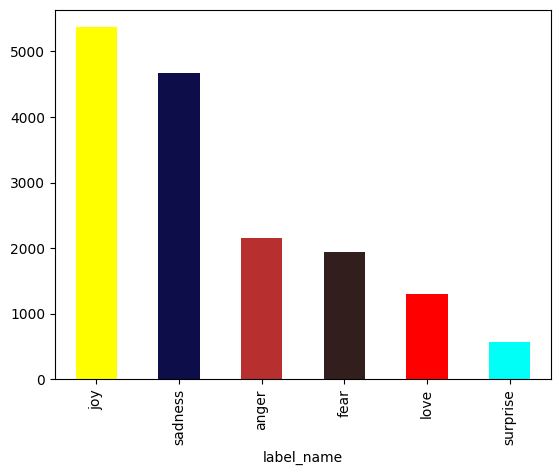

In [19]:
train_data["label_name"].value_counts().plot(kind='bar',color=['yellow', '#0c0d49', '#b82f2f', '#331e1e', 'red','#00fff7'])

# 2 | Data Cleaning

In [20]:
print(train_data.isnull().sum())
print(val_data.isnull().sum())
print(test_data.isnull().sum())

text          0
label         0
label_name    0
dtype: int64
text     0
label    0
dtype: int64
text     0
label    0
dtype: int64


# 3 | Tokenisation & Stemming

* <span style="background-color: #F8DE22; padding: 2px; border-radius:5px;">Tokenization</span> assigns unique IDs to words, creating a word index or vocabulary.
* <b>Example Sentence :</b> "Tokenization is essential for NLP tasks."
* <b>Tokenized Output : </b>['Tokenization', 'is', 'essential', 'for', 'NLP', 'tasks', '.']


* <span style="background-color: #F8DE22; padding: 2px; border-radius:5px;">Stemming</span> is a technique used to reduce an inflected word down to its word stem.
* <b>Example :</b>
* <b>Original Words :</b> running , programming , swimming , happiness , programmer <span style="background-color: #F8DE22; padding: 2px; border-radius:5px;">  (5 words)</span>
* <b>Stemmed Words :</b> run , program , swim , happi   <span style="background-color: #F8DE22; padding: 2px; border-radius:5px;">  (4 words)</span>

In [21]:
all_list = train_data['text'].tolist() + test_data['text'].tolist() + val_data['text'].tolist()

In [22]:
tokenizer1 = Tokenizer()
tokenizer1.fit_on_texts(all_list)
word_index1 = tokenizer1.word_index

print("Nombre of words without Stemming:",len(word_index1))

stemmer = PorterStemmer()
stemmed_words = [stemmer.stem(word) for word in word_index1.keys()]

tokenizer2 = Tokenizer()
tokenizer2.fit_on_texts(stemmed_words)
word_index2 = tokenizer2.word_index

print("Nombre of words with Stemming:",len(word_index2))

Nombre of words without Stemming: 17096
Nombre of words with Stemming: 11705


* load all data to list : <b>[ [ Tokenised_Data ] , label ] </b>

In [23]:
def preprocess_data(data):
    new_data = []
    for index, row in data.iterrows():
        test_split = row['text'].split()
        stemmed_words2 = [stemmer.stem(word) for word in test_split]
        token_list= tokenizer2.texts_to_sequences([stemmed_words2])[0]
        new_data.append([token_list,row['label']])
    return new_data

In [24]:
new_train_data = preprocess_data(train_data)
print(train_data['text'][0])
print(new_train_data[0])

i didnt feel humiliated
[[3198, 3265, 220, 665], 0]


In [25]:
new_val_data = preprocess_data(val_data)
print(val_data['text'][0])
print(new_val_data[0])

im feeling quite sad and sorry for myself but ill snap out of it soon
[[3205, 220, 595, 1335, 3199, 3326, 3206, 3227, 3207, 1326, 518, 1283, 1274, 1276, 3380], 0]


In [26]:
# Splitting into train_X and train_y
train_X = [row[0] for row in new_train_data]
train_y = [row[1] for row in new_train_data]

# Print the results
print("train_X:", train_X[0])
print("train_y:", train_y[0])

train_X: [3198, 3265, 220, 665]
train_y: 0


In [27]:
val_X = [row[0] for row in new_val_data]
val_y = [row[1] for row in new_val_data]

print("train_X:", val_X[0])
print("train_y:", val_y[0])

train_X: [3205, 220, 595, 1335, 3199, 3326, 3206, 3227, 3207, 1326, 518, 1283, 1274, 1276, 3380]
train_y: 0


### 3. 2 | Add Padding

In [28]:
length_of_longest_sentence = len(max(train_X, key=len))
print(length_of_longest_sentence)
print(max(train_X, key=len))

66
[3198, 613, 3250, 3588, 3217, 3204, 3198, 927, 3245, 1497, 3245, 1354, 3217, 3245, 1303, 1296, 3200, 2107, 1284, 1276, 3220, 220, 3598, 3213, 220, 1276, 3528, 3217, 7890, 4263, 3221, 5569, 1552, 3243, 3198, 4263, 3221, 1552, 5570, 5570, 3198, 3579, 5569, 3198, 7891, 1276, 3200, 3202, 1293, 3219, 1401, 3948, 3598, 3213, 3223, 239, 3528, 3213, 85, 3267, 579, 1658, 3206, 3201, 239, 1289]


In [29]:
for i in range(len(train_X)):
    for j in range(length_of_longest_sentence-len(train_X[i])):
        train_X[i].append(0)

for i in range(len(val_X)):
    for j in range(length_of_longest_sentence-len(val_X[i])):
        val_X[i].append(0)

### 3. 3 | List to Array (numpy)

In [30]:
train_X = np.array(train_X)
train_y = np.array(train_y)
val_X = np.array(val_X)
val_y = np.array(val_y)

print(train_X.shape,train_y.shape)
print(val_X.shape,val_y.shape)


(16000, 66) (16000,)
(3000, 66) (3000,)


In [31]:
# Convert labels to one-hot encoding
train_y_one_hot = to_categorical(train_y, num_classes=16000)
val_y_one_hot = to_categorical(val_y, num_classes=16000)

# 4 | Create model (LSTM)

### 4. 1 | Architechture of Bidirectional LSTM Neural Network

### 4. 2 | Bi- LSTM Neural Network Model training

In [32]:
model = Sequential()
model.add(Embedding(16000, 100, input_length=66))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(16000, activation='softmax'))
adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(train_X, train_y_one_hot, epochs=25, verbose=1,validation_data=(val_X,val_y_one_hot))
#print model.summary()
print(model)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.2896 - loss: 2.0073 - val_accuracy: 0.3540 - val_loss: 1.7452
Epoch 2/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.3029 - loss: 1.7283 - val_accuracy: 0.2787 - val_loss: 1.7782
Epoch 3/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.2956 - loss: 1.7259 - val_accuracy: 0.3550 - val_loss: 1.6165
Epoch 4/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.3065 - loss: 1.7138 - val_accuracy: 0.3550 - val_loss: 1.6318
Epoch 5/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.3101 - loss: 1.6881 - val_accuracy: 0.2797 - val_loss: 1.6484
Epoch 6/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.3155 - loss: 1.7057 - val_accuracy: 0.4743 - val_loss: 1.4486
Epoch 7/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.4943 - loss: 1.3940 - val_accuracy: 0.4927 - val_loss: 1.3899
Epoch 8/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.5222 - loss: 1.3090 - va

# 5 | Resultd And Test

### 5. 1 | Plotting Model Accuracy And Loss

### 5. 2 | Test The Model

### 5. 2 | Confusion Matrix